In [1]:
#Install elastic search
!pip install elasticsearch


In [2]:
!pip install -q pandas openai

In [3]:
# To search documents 

#Import Elasticsearch and helpers from  elasticsearch

from elasticsearch import Elasticsearch,helpers
import json

es = Elasticsearch(['http://localhost:9200'])
es.ping()   #connection testing
res = es.search(index="github_issues", body={"query": {"match_all": {}}})

# Extract the total hit count
print("Got %d Hits:" % res['hits']['total']['value'])

# Extract hits from the response
hits = res.get('hits', {})

# Pretty print the hits
print(json.dumps(hits, indent=2))

Got 1271 Hits:
{
  "total": {
    "value": 1271,
    "relation": "eq"
  },
  "max_score": 1.0,
  "hits": [
    {
      "_index": "github_issues",
      "_id": "FVJ_Ao8BU_R8dvYpNke4",
      "_score": 1.0,
      "_source": {
        "_type": "issue",
        "_repo": "openai-cookbook",
        "_issueNumber": "1161",
        "_title": "Update registry.yaml",
        "_createdAt": "2024-04-19T18:32:11Z",
        "_closedAt": "2024-04-19T19:05:01Z",
        "_state": "closed",
        "_body": "forgot to update registry.yaml with modified filename.\r\n",
        "GitHub_Issue_vector": [
          0.004572148434817791,
          0.006025981158018112,
          0.0044927229173481464,
          -0.01693490520119667,
          -0.00962084997445345,
          0.022432534024119377,
          -0.02555430307984352,
          -0.005829143803566694,
          -0.002729821251705289,
          -0.022487787529826164,
          0.02317844331264496,
          -0.008771342225372791,
          0.0076593845

In [4]:
hits['hits'][5]['_source']  # Choose an Issue from Issues in repository

{'_type': 'issue',
 '_repo': 'openai-cookbook',
 '_issueNumber': '1156',
 '_title': 'Codespace stunning space umbrella jjg7w544957fq7vq',
 '_createdAt': '2024-04-18T04:23:21Z',
 '_closedAt': '2024-12-31T00:36:30Z',
 '_state': 'open',
 '_body': '## Summary\r\n\r\nBriefly describe the changes and the goal of this PR. Make sure the PR title summarizes the changes effectively.\r\n\r\n## Motivation\r\n\r\nWhy are these changes necessary? How do they improve the cookbook?\r\n\r\n---\r\n\r\n## For new content\r\n\r\nWhen contributing new content, read through our [contribution guidelines](https://github.com/openai/openai-cookbook/blob/main/CONTRIBUTING.md), and mark the following action items as completed:\r\n\r\n- [ ] I have added a new entry in [registry.yaml](https://github.com/openai/openai-cookbook/blob/main/registry.yaml) (and, optionally, in [authors.yaml](https://github.com/openai/openai-cookbook/blob/main/authors.yaml)) so that my content renders on the cookbook website.\r\n- [x] I h

In [5]:
import json
from elasticsearch import Elasticsearch

# Initialize the Elasticsearch client
es = Elasticsearch(["http://localhost:9200"])

# List of repositories
repositories = [
    {"owner": "openai", "repo": "openai-cookbook"},
    {"owner": "elastic", "repo": "elasticsearch"},
    {"owner": "openai", "repo": "openai-python"},
    {"owner": "milvus-io", "repo": "pymilvus"},
    {"owner": "SebastianM", "repo": "angular-google-maps"}
]

responses = []  # Define responses list here

# Loop through each repository
for repo_info in repositories:
    repo_owner = repo_info["owner"]
    repo_name = repo_info["repo"]
    full_repo_name = f"{repo_owner}/{repo_name}"
    
    # Constructing a simple match query (you might need to modify this according to your index structure)
    query_body = {
        "size": 5,  # Limit the number of results
        "query": {
            "bool": {
                "must": {
                    "match": {
                        "_repo": full_repo_name  # Ensure this field name matches your Elasticsearch index
                    }
                }
            }
        }
    }

    # Execute the search query
    response = es.search(index="github_issues", body=query_body)

    # Handle response
    if response.get("hits", {}).get("hits"):
        similar_issues = [
            {
                "_score": hit["_score"],
                "_type": hit.get("_source", {}).get("_type", ""),
                "_repo": hit.get("_source", {}).get("_repo", ""),
                "_issueNumber": hit.get("_source", {}).get("_issueNumber", ""),
                "_title": hit.get("_source", {}).get("_title", ""),
                "_createdAt": hit.get("_source", {}).get("_createdAt", ""),
                "_closedAt": hit.get("_source", {}).get("_closedAt", ""),
                "_body": hit.get("_source", {}).get("_body", ""),
            }
            for hit in response["hits"]["hits"]
        ]
        responses.extend(similar_issues)
        
        # Print or store the top 5 most similar issues for the current repository
        print(f"Top 5 most similar issues for {full_repo_name}:")
        for issue in similar_issues:
            print(issue)
    else:
        print(f"No similar issues found for {full_repo_name}")





Top 5 most similar issues for openai/openai-cookbook:
{'_score': 6.7965703, '_type': 'issue', '_repo': 'openai-cookbook', '_issueNumber': '1161', '_title': 'Update registry.yaml', '_createdAt': '2024-04-19T18:32:11Z', '_closedAt': '2024-04-19T19:05:01Z', '_body': 'forgot to update registry.yaml with modified filename.\r\n'}
{'_score': 6.7965703, '_type': 'issue', '_repo': 'openai-cookbook', '_issueNumber': '1160', '_title': '[FEATURE]', '_createdAt': '2024-04-18T05:57:20Z', '_closedAt': '2024-12-31T00:36:30Z', '_body': "[optional template]\r\n\r\n**Is your feature request related to a problem? Please describe.**\r\nA clear and concise description of what the problem is. Ex. I'm always frustrated when [...]\r\n\r\n**Describe the solution you'd like**\r\nA clear and concise description of what you want to happen.\r\n\r\n**Additional context**\r\nAdd any other context or screenshots about the feature request here.\r\n\r\n```[tasklist]\r\n### Tasks\r\n- [ ] https://github.com/openai/openai

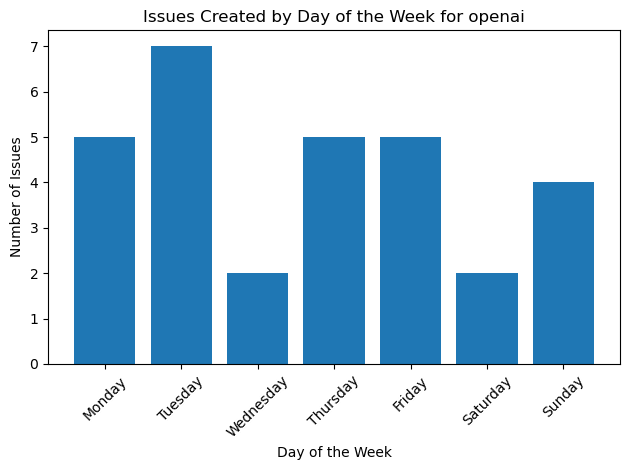

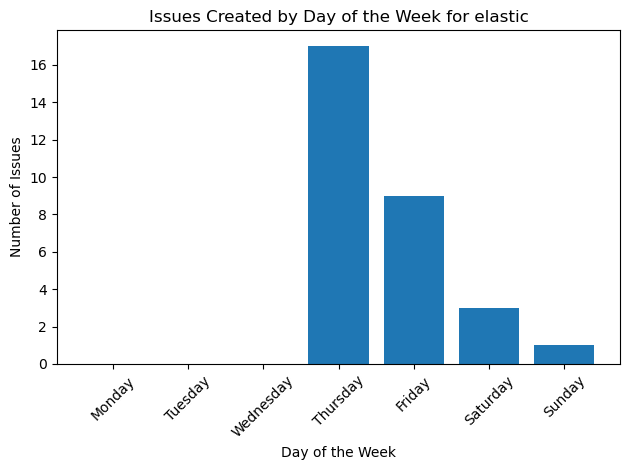

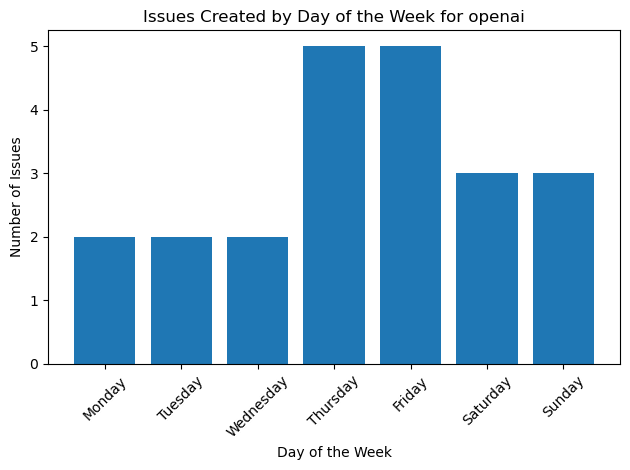

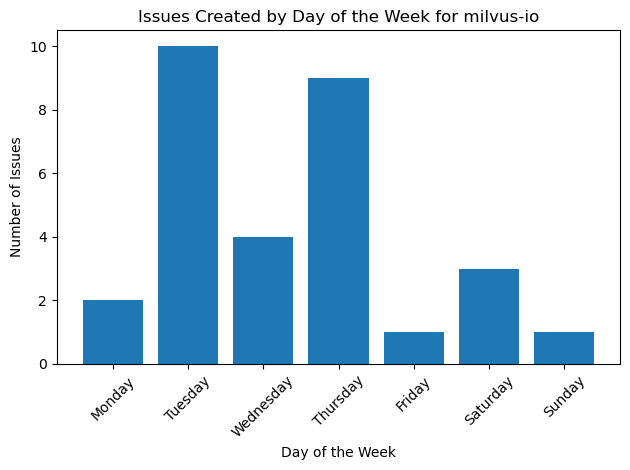

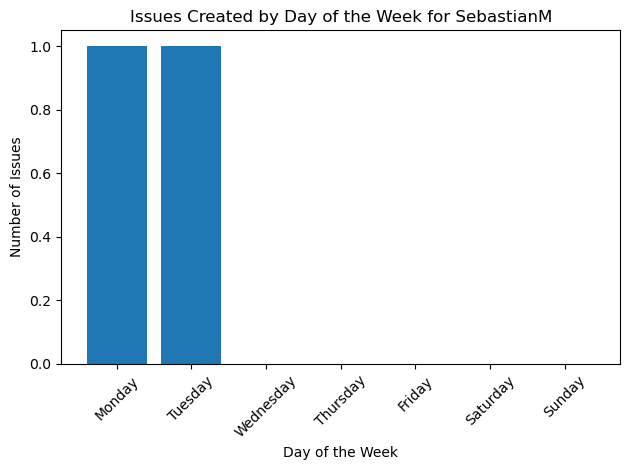

In [6]:
from collections import defaultdict
from datetime import datetime, timedelta
import requests
import matplotlib.pyplot as plt

# GitHub API endpoint for issues
API_URL = "https://api.github.com/repos/{}/issues"

# Function to fetch issues for a repository
def fetch_issues(repo_url):
    repo_name = repo_url.split("/")[-2] + "/" + repo_url.split("/")[-1]
    response = requests.get(API_URL.format(repo_name))
    if response.status_code == 200:
        return response.json()
    else:
        print("Failed to fetch issues for", repo_url)
        print("Status code:", response.status_code)
        print("Response:", response.text)
        return []

# Function to filter issues for the past 2 months
def filter_issues_for_past_2_months(issues):
    two_months_ago = datetime.now() - timedelta(days=30*2)
    return [issue for issue in issues if datetime.strptime(issue['created_at'], '%Y-%m-%dT%H:%M:%SZ') > two_months_ago]

# Function to count the number of issues created on each day of the week for every repository
def count_issues_per_day_of_week(issues):
    issues_per_day = defaultdict(int)
    for issue in issues:
        created_at = datetime.strptime(issue['created_at'], '%Y-%m-%dT%H:%M:%SZ')
        day_of_week = created_at.strftime('%A')  # Get the day of the week (e.g., Monday)
        issues_per_day[day_of_week] += 1
    return issues_per_day

# Function to create a bar chart of issues created on each day of the week for every repository
def plot_issues_per_day_of_week(repo_name, issues_per_day):
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    issue_counts = [issues_per_day[day] for day in days_of_week]
    
    plt.bar(days_of_week, issue_counts)
    plt.title('Issues Created by Day of the Week for {}'.format(repo_name))
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Issues')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Repositories to analyze
repositories = [
    "https://github.com/openai/openai-cookbook",
    "https://github.com/elastic/elasticsearch",
    "https://github.com/openai/openai-python",
    "https://github.com/milvus-io/pymilvus",
    "https://github.com/SebastianM/angular-google-maps"
]

# Fetch, filter, and plot issues for each repository
for repo in repositories:
    issues = fetch_issues(repo)
    if issues:
        issues = filter_issues_for_past_2_months(issues)
        issues_per_day = count_issues_per_day_of_week(issues)
        plot_issues_per_day_of_week(repo.split("/")[-2], issues_per_day)